In [1]:
import numpy as np
import pandas as pa
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [2]:
df = pa.read_hdf('data.hdf')

Index(['sweeps', 'A2_power', 'init_time', 'trans', 'readout', 'n_pulses',
       'tau_2', 'phase_pi2_2', 'result_0', 'trace', 'ple_A2', 'ple_A1',
       'average_counts', 'events', 'thresholds', 'start_time', 'end_time',
       'mw_mixing_frequency', 'local_oscillator_freq', 'confocal_x',
       'confocal_y', 'confocal_z', 'aom_Ex_power_measured',
       'aom_A1_power_measured', 'Ex_RO_power_measured',
       'EOM_Ex_integrator_voltage', 'windows_ps', 'delays_ps'],
      dtype='object')

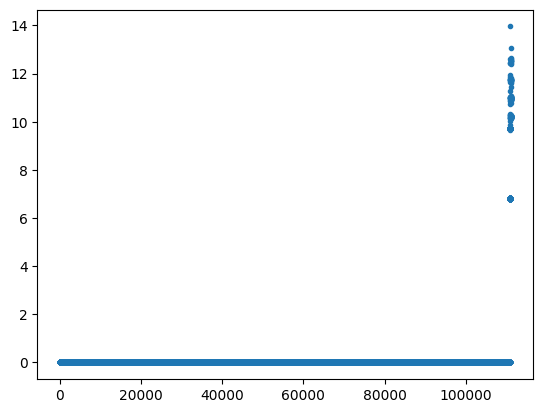

In [3]:
plt.plot(df.loc[:].average_counts,'.')
df = df.loc[:]
df.keys()

In [62]:
df_Sub = df.groupby(['phase_pi2_2','tau_2', 'sweeps']).average_counts.agg('mean')
max_sweep = max(df.sweeps.unique())

In [251]:
# nuclear baths
Bfield = 881*1 # Gaus
gamma_C = 1.07 #G/kHz
gamma_Si = -0.8465 #G/kHz
pi2_duration = 0.05*1e-3 # in ms
larmor_C = Bfield*gamma_C # in kHz
larmor_Si = abs(Bfield*gamma_Si) # in kHz
bath_C = 1/(2*larmor_C)+pi2_duration # in ms
bath_Si = abs(1/(2*larmor_Si))+pi2_duration # in ms, is physical to use absolute value?
print(bath_C)
print(bath_Si)

0.0005804083083157415
0.0007204511398675054


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 20015.58it/s]


<IPython.core.display.Javascript object>


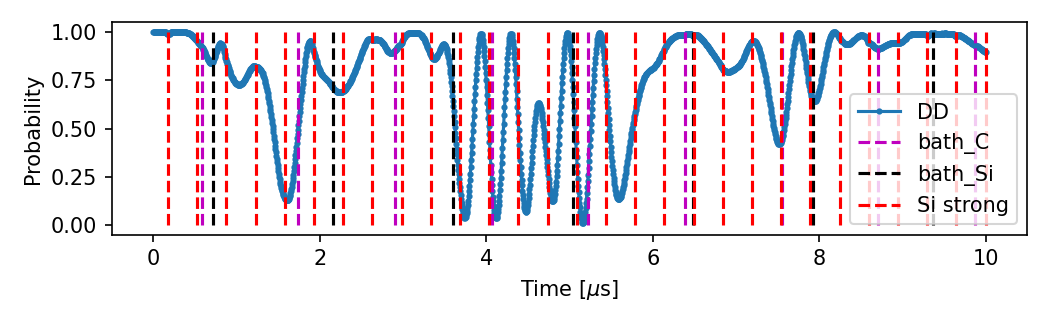

In [252]:
#######################################################################################################################
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
# Dynamical Decoupling = DD
s1, s0 = 1.5, 0.5
def DD(FL, Azz, Azx, tau, N_pi, s1= s1, s0=s0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

start = 8e-9 # in ms
duration = 10e-3 # in ms
incre = 6.6e-6
# Taus = np.arange(start,start+duration, incre) # in ms
Taus = df.tau_2.unique() *1e-3 # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4) # number of measurements needed for noise generated signal


tau_bath_C = np.array([bath_C *odd for odd in range(50) if odd%2==1 and bath_C*odd<max(Taus)]) # in ms
tau_bath_Si = np.array([bath_Si*odd for odd in range(50) if odd%2==1 and bath_Si*odd<max(Taus)])

# determining the parameters
Azz = np.array([2090, -610]) # kHz
Azx = np.array([-290, -150]) # kHz
bath_larmor= np.array([larmor_Si, larmor_C])
Om0 = np.sqrt((bath_larmor+s0*Azz)**2+(s0*Azx)**2)
Om1 = np.sqrt((bath_larmor+s1*Azz)**2+(s1*Azx)**2)
tau_Si = np.array(
    [abs(odd/((Om0+Om1)))[0] for odd in range(100) if odd%2==1 and abs(odd/((Om0+Om1)))[0]<max(Taus)])
# Bath
num_bath = 100
num_bath_C = 0.2*num_bath
num_bath_Si = num_bath - num_bath_C 
Azz = np.append(Azz, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath in kHz
Azx = np.append(Azx, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath in kHz
bath_larmor  = np.append(bath_larmor, np.array([larmor_C]*int(num_bath_C)))
bath_larmor  = np.append(bath_larmor, np.array([larmor_Si]*int(num_bath_Si)))


sigmaz_DD = []
for tau in tqdm(Taus):
    sigmaz_DD.append(DD(bath_larmor, Azz, Azx, tau/2, N_pi))
sigmaz_DD = np.array(sigmaz_DD) # signal is just sigma_z from -1 to 1
p = 0.5-0.5*sigmaz_DD #probability to be in the initial state (bright state) from 0 to 1
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5*2,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, label='DD')
plt.vlines(tau_bath_C*1000, ymin=0, ymax=1, color='m', label='bath_C', linestyles ='dashed')
plt.vlines(tau_bath_Si*1000, ymin=0, ymax=1, color='black', label='bath_Si', linestyles ='dashed')
plt.vlines(tau_Si*1000, ymin=0, ymax=1, color='red', label='Si strong', linestyles ='dashed')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.tight_layout()
plt.legend()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
# plt.savefig('DD_all_64pulse_zoom.png',dpi=150)

<IPython.core.display.Javascript object>


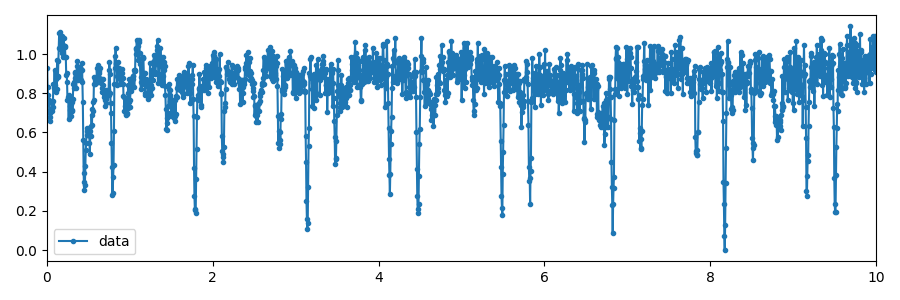

(0.0, 10.0)

In [253]:
%matplotlib notebook
tau = df.tau_2.unique()
fig, ax1 = plt.subplots(1,1, figsize = (9,3), tight_layout = True)
y1 = np.zeros(len(tau))
y2 = np.zeros(len(tau))
for sweep in df.sweeps.unique():  
    if sweep != 27: #exclude last sweep which was bad
        y1+= np.array(df_Sub.loc[0, :, sweep])
        y2+= np.array(df_Sub.loc[180, :, sweep])
y = y2-y1
y = y/max(y)
y = 0.5-0.5*y

ax1.plot(tau,y,'.-',label='data')
# ax1.plot(Taus*1000, p, '-o',markersize=2, label='DD')
# ax1.vlines(tau_bath_C*1000, ymin=0, ymax=1, color='m', label='bath_C',linestyles ='dashed')
# ax1.vlines(tau_bath_Si*1000, ymin=0, ymax=1, color='black', label='bath_Si', linestyles ='dashed')
# ax1.vlines(tau_Si*1000, ymin=0, ymax=1, color='red', label='Si strong', linestyles ='dashed')
ax1.legend()
#ax1.plot(tau,y_2,'.-')
ax1.set_xlim([0,10])

#plt.show()

<IPython.core.display.Javascript object>


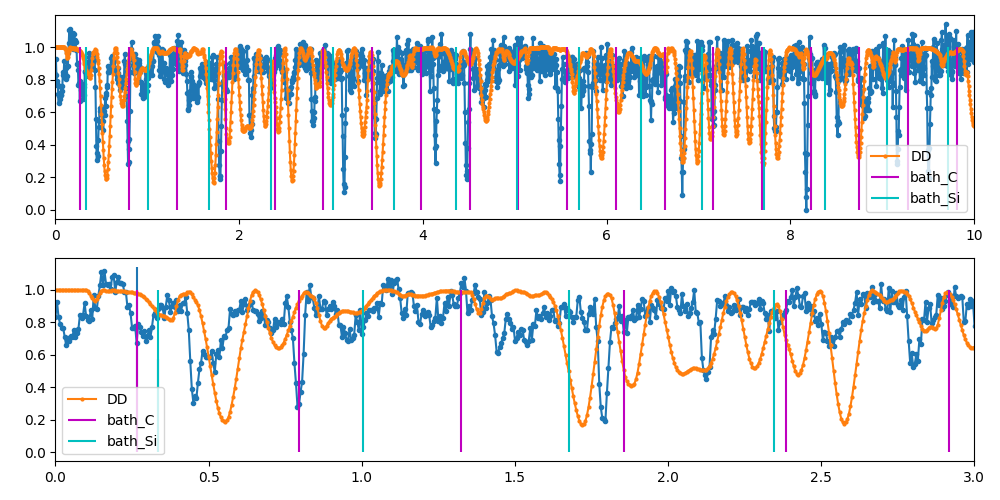

In [69]:
%matplotlib notebook
tau = df.tau_2.unique()
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,5))
y1 = np.zeros(len(tau))
y2 = np.zeros(len(tau))
for sweep in df.sweeps.unique():  
    if sweep != 27: #exclude last sweep which was bad
        y1+= np.array(df_Sub.loc[0, :, sweep])
        y2+= np.array(df_Sub.loc[180, :, sweep])
y = y2-y1
y = y/max(y)
y = 0.5-0.5*y

ax1.plot(tau,y,'.-')
ax2.plot(tau,y,'.-')
ax1.plot(tau, p, '-o',markersize=2, label='DD')
ax1.vlines(tau_bath_C, ymin=0, ymax=1, color='m', label='bath_C')
ax1.vlines(tau_bath_Si, ymin=0, ymax=1, color='c', label='bath_Si')
ax1.legend()
#ax1.plot(tau,y_2,'.-')
#ax2.plot(tau,y_2,'.-')
ax2.vlines(bath_C,min(y),max(y))
ax2.vlines(bath_Si,min(y),.5*max(y))
# ax2.text(bath_C+0.01, .8*max(y),'C bath')
# ax2.text(bath_Si+0.01, .5*max(y),'Si bath')
ax2.plot(tau, p, '-o',markersize=2, label='DD')
ax2.vlines(tau_bath_C, ymin=0, ymax=1, color='m', label='bath_C')
ax2.vlines(tau_bath_Si, ymin=0, ymax=1, color='c', label='bath_Si')
ax1.set_xlim([0,10])
ax2.set_xlim([0,3])
ax2.legend()
plt.tight_layout()
#plt.show()

In [25]:
tau = df.tau_2.unique()
tau

array([0.000e+00, 5.000e-03, 1.000e-02, ..., 9.990e+00, 9.995e+00,
       1.000e+01])